In [1]:
import os, sys
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import pandas as pd
import time

from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

sys.path.append(os.path.join(os.path.dirname(""), "..", ".."))
from utils.data_loader import fetch_dataframe
import utils.constants as consts
from utils.moirai_utils import generate_model_input, preprocess_data, get_predictions, plot_results, mean_absolute_percentage_error


load_dotenv()

True

Source: https://github.com/anamabo/medium-blogs/tree/main/moirai-moe

In [2]:
DATA_PATH = os.path.join(os.path.dirname(""), "..", "..", 'data')

In [3]:
df_raw = fetch_dataframe(table_name=consts.COMPRESSOR_TABLE)
df_raw.head(2)

,timestamp,on,motor_power,disch_T_1,disch_T_2,disch_P_1,disch_P_2,suc_T_1,suc_T_2,suc_P_1,suc_P_2,mass_flow,vol_flow,flow_1,flow_2,vib_1_1,vib_1_2,vib_2_1,vib_2_2
0,2024-11-09 00:00:00,1.0,NaN,123.020853,122.029697,11.834169,11.878711,36.041114,36.077477,2.648403,2.647707,164658.029345,50174.901314,154.385422,164496.675658,65.242229,32.972047,55.414968,37.332564
1,2024-11-09 00:02:00,1.0,NaN,122.852380,121.882858,12.877664,12.914020,35.315496,35.360262,3.168737,3.165845,188763.306135,50248.396702,188.119074,188839.063117,65.364050,33.625440,56.142601,37.276339


In [4]:
df = df_raw[[consts.TIMESTAMP, consts.DISCH_T_1]]
df.isna().sum()

timestamp      0
disch_T_1    196
dtype: int64

In [5]:
# do some quick imputation
df = df.ffill()

In [6]:
df.head(2)

,timestamp,disch_T_1
0,2024-11-09 00:00:00,123.020853
1,2024-11-09 00:02:00,122.852380


MOIRAI-MOE Getting Started

In [7]:
MODEL_PARAMS = {
"patch_size":16,  # 8, 16, 32, 64, 128
"num_samples": 100,
"target_dim": 1,
"feat_dynamic_real_dim": 0,
"past_feat_dynamic_real_dim": 0,
}

In [8]:
date_colname= consts.TIMESTAMP
target_colname = consts.DISCH_T_1

total length: 258967
Index(['disch_T_1'], dtype='object')
time frequency: 0 days 00:02:00
2024-11-09 00:00:00 2025-11-03 18:00:00


<Axes: xlabel='timestamp'>

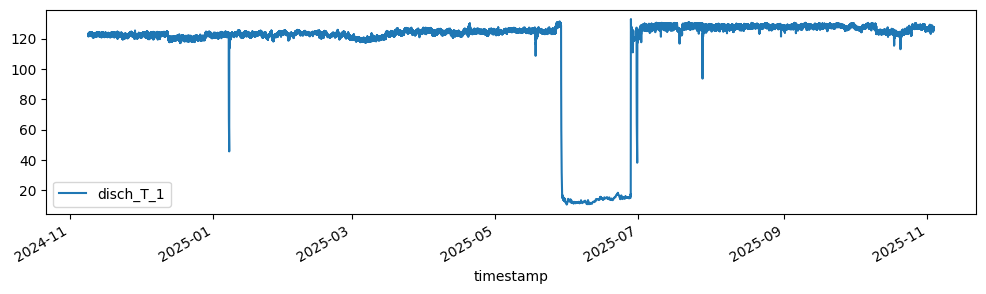

In [9]:
df[date_colname] = pd.to_datetime(df[date_colname])
df.set_index(date_colname, inplace=True)  # Normalize the target variable

print(f"total length: {df.shape[0]}")
print(df.columns)
print(f"time frequency: {df.index.diff()[1]}")
print(df.index[0], df.index[-1])
df.plot(figsize=(12, 3))

Zero-shot Prediction

torch.Size([1, 180, 1])
torch.Size([1, 180, 1])
torch.Size([1, 180])


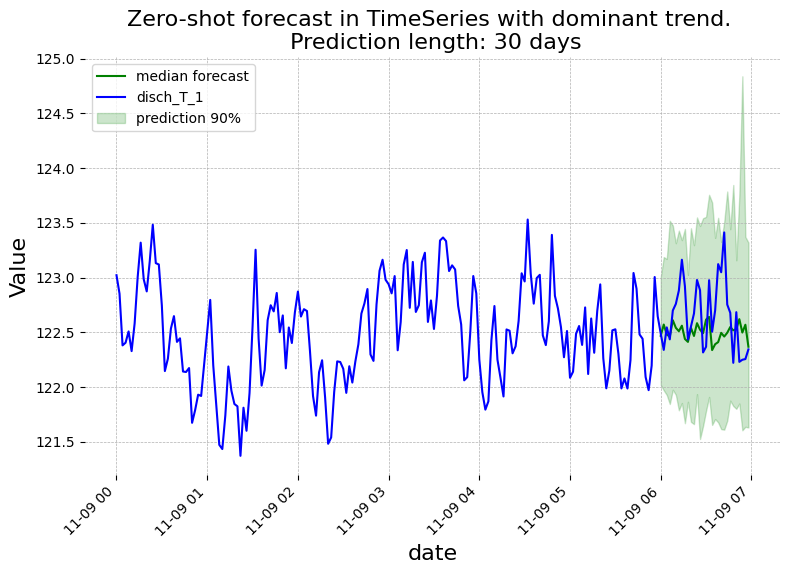

In [19]:
# create the train and test sets
train_window = 6 * 30 # value is in days
prediction_window = 30  # predict the following X days

train = df.iloc[:train_window, :].copy()
test = df.iloc[train_window:, :].copy()

# preprocess the data
target_tensor, is_target_observed, is_target_padded= preprocess_data(target=train[target_colname].values)

print(target_tensor.shape)
print(is_target_observed.shape)
print(is_target_padded.shape)

# Define the model
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
    prediction_length= prediction_window,
    context_length=train_window,
    **MODEL_PARAMS,
)

# Make the forecast
forecast = model(
    past_target=target_tensor,
    past_observed_target=is_target_observed,
    past_is_pad=is_target_padded,
)

# Collect the median forecast and CI into a DataFrame
predictions_df = get_predictions(
    forecast_tensor=forecast[0],
    train_set=train,
    date_colname=date_colname
)

# Merge predictions with original data
true_and_preds = pd.merge(test, predictions_df, left_index=True, right_index=True, how="right")
all_data = pd.concat([train.iloc[-train_window:, :], true_and_preds])

# # Plot the results
figure = plot_results(
    results_df=all_data,
    target_colname=target_colname,
    title=f"Zero-shot forecast in TimeSeries with dominant trend. \n Prediction length: {prediction_window} days",
    figsize=(8, 6)
)
plt.show()

Rolling Forecast

In [20]:
# create the train and test sets
train_window = 6 * 30 # value is in days
prediction_window = 10  # predict the following X days
niter = 3  # iterations for the rolling forecast
MODEL_PARAMS["patch_size"] = 16

train = df.iloc[:train_window, :].copy()
test = df.iloc[train_window:, :].copy()

frequency = train.index.diff()[1]
train_original = train.copy()  # to be used for plotting

# Rolling forecast
all_predictions = []
for i in range(niter):
    print(f"interation: {i}")
    if i == 0:
        # Use the original train
       train = generate_model_input(train_df=train, date_colname=date_colname, target_colname=target_colname, median_forecast=None)

    elif last_date_train + frequency * prediction_window in test.index:
        # In case you receive new input data (here represented by the test)
        train = generate_model_input(
           train_df=train,
           date_colname=date_colname,
           target_colname=target_colname,
           median_forecast=test.loc[last_date_train + frequency: last_date_train + frequency * prediction_window, target_colname].values
       )

    else:
        # Use forecast to create another forecast
       train = generate_model_input(
           train_df=train,
           date_colname=date_colname,
           target_colname=target_colname,
           median_forecast=predictions_df["median_forecast"].values
       )

    # Preprocess the new train set
    target_tensor, is_target_observed, is_target_padded = preprocess_data(
        target=train[target_colname].values
    )

    # Prepare model
    model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
    prediction_length=prediction_window,
    context_length=train_window+i*prediction_window,  # Train context is not rolling, it always stars from the beginning
    **MODEL_PARAMS,
    )

    forecast = model(
        past_target=target_tensor,
        past_observed_target=is_target_observed,
        past_is_pad=is_target_padded,
    )

    predictions_df= get_predictions(
        forecast_tensor=forecast[0],
        train_set=train,
        date_colname=date_colname
    )
    last_date_train = predictions_df.index[-1]

    all_predictions.append(predictions_df)

all_predictions_df = pd.concat(all_predictions)

interation: 0
interation: 1
interation: 2


0.22168052424412407


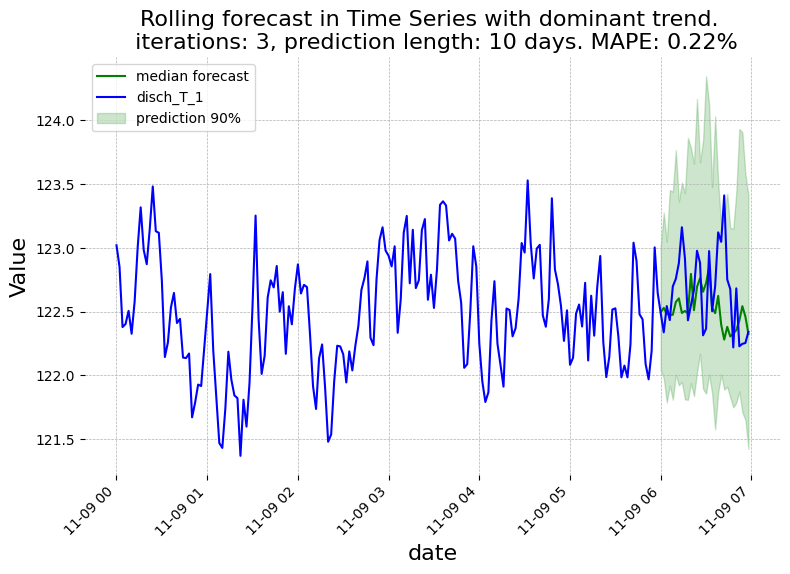

In [21]:
true_and_preds = pd.merge(test, all_predictions_df, left_index=True, right_index=True, how="right")
all_data = pd.concat([train_original.iloc[train_window-train_window:, :], true_and_preds])

# Get the forecast error
mape_rolling = mean_absolute_percentage_error(
        y_true=true_and_preds[target_colname].values,
        y_pred=true_and_preds["median_forecast"].values
    )

print(mape_rolling)

figure = plot_results(
    results_df=all_data,
    target_colname=target_colname,
    title=f"Rolling forecast in Time Series with dominant trend. \n iterations: {niter}, prediction length: {prediction_window} days. MAPE: {mape_rolling:.2f}%",
    figsize=(8, 6)
)
plt.show()